## Equifax Analytic Dataset - ABS Collateral Performance by Type

#### Author: Barry Zihao Qie
#### Project Start Date: Feb 27th, 2022
#### Last Version Update: Mar 16th, 2023

In [1]:
import os

path = os.getcwd()

print(path)

C:\Users\zihao\OneDrive\Desktop\Jupyter Notebook\Consumer ABS Jupyter Notebooks


In [2]:
os.chdir("C:\\Users\\zihao\\OneDrive\\Desktop\\Citi Work\\ABS Research\\1010 XMLquery\\Equifax Analytics Dataset\\Labor Market - Regression")

path=os.getcwd()

print(path)

C:\Users\zihao\OneDrive\Desktop\Citi Work\ABS Research\1010 XMLquery\Equifax Analytics Dataset\Labor Market - Regression


In [3]:
# imports
import pandas as pd
import numpy as np
import time
from datetime import datetime
import matplotlib.pyplot as plt 
from matplotlib import ticker
import matplotlib.dates as mdates
import seaborn as sns
import py1010
import sys
from dateutil.relativedelta import relativedelta, FR

In [4]:
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

In [5]:
cur_month= datetime.now().replace(day=1).strftime(format="%#m/%Y")
prev_month = (datetime.now().replace(day=1) + relativedelta(months=-1)).strftime(format="%#m/%Y")
print(cur_month)
print(prev_month)

6/2023
5/2023


In [6]:
gateway  = "https://www2.1010data.com/cgi-bin/gw"
tablename = "pub.fin.efxas.client.v3.v3_panel_data"
username = "citi_zqie"
password = "Barry0228Qzh"

In [7]:
folder_path='C:\\Users\\zihao\\OneDrive\\Desktop\\Citi Work\\ABS Research\\1010 XMLquery\\Equifax Analytics Dataset\\Labor Market - Regression'
print(folder_path)

C:\Users\zihao\OneDrive\Desktop\Citi Work\ABS Research\1010 XMLquery\Equifax Analytics Dataset\Labor Market - Regression


In [8]:
query_path = folder_path
files=os.listdir(query_path)
query_list=[]
for i in files:
    query_list.append(i)

print(len(query_list))
print(query_list)

2
['consumer dq by state_FICO.txt', 'monthly_state_unempSA.txt']


In [9]:
from argparse import Namespace

settings = Namespace(
    
    #Chart Settings
    title_fontsize = 18,
    fig_size=(12,6),
    
    # BackUP Settings
    root_directory = 'C:\\Users\\zihao\\OneDrive\\Desktop\\Citi Work\\ABS Research\\Equifax Dataset Charts',
    report_directory = 'Chart_Content',
    backup_directory = 'BACKUP',
    
    #Chart Name Settings
    report_name = 'ExampleReport',
    rep_extn = ".png",
    backup_name_format = '%Y-%m-%d'
)

In [10]:
start_date = input('What is the start date of your plot Specify to this format: 2005-07-01')

What is the start date of your plot Specify to this format: 2005-07-01 2005-07-01


In [11]:
print(start_date)
type(start_date)

2005-07-01


str

### Seperator Line -------------------- FUNCTIONS--------------------

In [12]:
def Get_1010Data(q):
    session = py1010.Session(gateway,username,password,py1010.KILL)
    tablename = "pub.fin.efxas.client.v3.v3_panel_data"
    
    row_list = []
    headers = []
    try:
        query = session.query(tablename, q)
        query.run()
        for r in range(query.nrows):
            row_list.append(query.getrow(r))
        for c in query.cols:
            headers.append(c.name)
        
        df = pd.DataFrame(row_list,columns=headers)
        for col in df.columns:
            if isinstance(df[col][1],bytes):
                df[col] = df[col].str.decode("utf-8")
    
    except py1010.TentenException as e:
        print("Error: {}".format(e))
    
    session.close()
    print("result saved as a dataframe, and 1010 session closed")
    
    return df

In [13]:
def get_DQ_pivot(df):
    #df['fico_bucket'] = df['fico_bucket'].astype('category')
    #dq_hist = df.set_index(['date','fico_bucket'])
    dq_hist['end_bal_date_fico']=dq_hist.groupby(level=['date','fico_bucket'])['sum_balance'].sum()
    dq_hist['dq_percent'] = dq_hist['sum_balance']/dq_hist['end_bal_date_fico']
    dq_pivot = pd.pivot_table(dq_hist,values=['dq_percent'], columns=['date','fico_bucket','dq_bucket'],aggfunc=[np.sum])
    return dq_pivot.transpose()

In [14]:
def get_consumerDQ_pivot_bystate(df):
    #df['state']=df['state'].astype('category')
    dq_hist = df.set_index(['date','state'])
    dq_hist['bal_date_state']=dq_hist.groupby(level=['date','state'])['sum_balance'].sum()
    dq_hist['dq_percent'] = dq_hist['sum_balance']/dq_hist['bal_date_state']
    dq_pivot = pd.pivot_table(dq_hist,values=['dq_percent'], columns=['date','state','dq_bucket'],aggfunc=[np.sum])
    return dq_pivot.transpose()

In [15]:
def get_consumerDQ_pivot_bystate_fico(df):
    #df['state']=df['state'].astype('category')
    #df['fico_bucket']=df['fico_bucket'].astype('category')
    dq_hist = df.set_index(['date','state','fico_bucket'])
    dq_hist['bal_date_statefico']=dq_hist.groupby(level=['date','state','fico_bucket'])['sum_balance'].sum()
    dq_hist['dq_percent'] = dq_hist['sum_balance']/dq_hist['bal_date_statefico']
    dq_pivot = pd.pivot_table(dq_hist,values=['dq_percent'], columns=['date','state','fico_bucket','dq_bucket'],aggfunc=[np.sum])
    return dq_pivot.transpose()

In [16]:
def merge_vectors(unemp_df,PL_dq_df):
    pl_unemp_df = unemp_df.merge(PL_dq_df, how = 'inner', on=['date','state'])
    pl_unemp_df = pl_unemp_df.rename(columns={'dq_percent':'dq60+_percent'})
    pl_unemp_df['dq60+_percent'] = pl_unemp_df['dq60+_percent']*100
                                 
    return pl_unemp_df

In [17]:
def get_polyfit_rsquared(x,y,degree):
    results = {}
    coeffs = np.polyfit(x,y,degree)
    
    results['parameters'] = coeffs.tolist()
    
    # r-squared 
    p = np.poly1d(coeffs)
    
    yhat = p(x)
    ybar = np.sum(y)/len(y)
    ssreg = np.sum((yhat-ybar)**2)
    sstot = np.sum((y-ybar)**2)
    
    results['determination'] = ssreg / sstot
    
    return results

In [18]:
def save_chart(fig, figname):
    
    rep_path = os.path.join(settings.root_directory, settings.report_directory)
    if not os.path.exists(rep_path):
        os.makedirs(rep_path)
    
    filename = figname + settings.rep_extn
    fig.savefig(os.path.join(rep_path,filename))
    
    backup_path=os.path.join(rep_path, settings.backup_directory)     
    if not os.path.exists(backup_path):
        os.makedirs(backup_path)
    
    backup_date = datetime.today().strftime(settings.backup_name_format)
    backup_filename = figname + "_" + backup_date + settings.rep_extn
    fig.savefig(os.path.join(backup_path, backup_filename))
    
    print('chart saved to the target and BACKUP directory in this following directory: ' + rep_path)

### ___MAIN___

### The below exercise is trying to answer the following question: How does unemployment rate affect the consumer oan delinquency 60+ (and more severe derogatory stages)?

### Do the by FICO Charts Directly

- we have unemployment data by state from FRED-BLS, sitting in 1010 base table: pub.finfred2.bls.smsa
- consumer loan data from Equifax, using the DQ 60+ % of loan balance, and tabulation by state. Earliest data available is 2005/07 base table: pub.fin.efxas.client.v3.v3_panel_data

#### Consumer Loan DQ

Criteria for Loans selected in the below query:
- origination product category: "OT1" or "CFI"
- acct_type : 'unsecured"
- portfolio_type = 'I'

In [19]:
file=open('consumer dq by state_FICO.txt','r')
lines=file.readlines()
q = [line.rstrip().lstrip() for line in lines]
file.close()
q="".join(q)

print(q)

<base table="pub.fin.efxas.client.v3.v3_panel_data"/><willbe name="fico_bucket" value="iff(vantage_score_3<=660;'below 660';vantage_score_3<=720;'660-720';vantage_score_3>720;'above 720';'na')"/><willbe name="date" value="year(archive_date)*10000+month(archive_date)*100+1" format="type:date"/><willbe name="orig_date" value="year(origination_date_open)*10000+month(origination_date_open)*100+1" format="type:date"/><willbe name="dq_bucket" value="iff(status_category=1;'Current and less than 30 DQ';status_category=2;'31-60 DQ';status_category=3 4 5 8 9;'60+ DQ and more severe, including closure';'else')"/><willbe name="is_p12" value="iff(origination_product_category='CFI' 'OT1' & acct_type_desc='Unsecured' & portfolio_type='I';1;0)"/><willbe name="is_p1" value="g_hi(consumer_id trade_id;;is_p12)"/><sel value="is_p1=1"/><tabu breaks="date,state,fico_bucket,dq_bucket"><tcol fun="sum" name="sum_balance" source="balance"/><tcol fun="ucnt" name="ucnt_consumer_id" source="consumer_id"/></tabu><s

In [20]:
consumer_dqbystate_raw = Get_1010Data(q)

result saved as a dataframe, and 1010 session closed


In [21]:
pd.concat([consumer_dqbystate_raw.head(10),consumer_dqbystate_raw.tail(10)])

,date,state,fico_bucket,dq_bucket,sum_balance,ucnt_consumer_id
0,2005-07-01,,below 660,Current and less than 30 DQ,13290.0,1.0
1,2005-07-01,,below 660,else,0.0,1.0
2,2005-07-01,AA,660-720,Current and less than 30 DQ,50047.0,9.0
3,2005-07-01,AA,660-720,else,3063.0,5.0
4,2005-07-01,AA,above 720,Current and less than 30 DQ,152783.0,13.0
5,2005-07-01,AA,above 720,else,0.0,4.0
6,2005-07-01,AA,below 660,"60+ DQ and more severe, including closure",7587.0,7.0
7,2005-07-01,AA,below 660,Current and less than 30 DQ,121184.0,35.0
8,2005-07-01,AA,below 660,else,2880.0,15.0
9,2005-07-01,AE,660-720,"60+ DQ and more severe, including closure",3104.0,5.0


In [22]:
consumer_dqbystate_raw['date'] = pd.to_datetime(consumer_dqbystate_raw['date'].to_numpy())

In [23]:
consumer_dqbystate_fico_pivot = get_consumerDQ_pivot_bystate_fico(consumer_dqbystate_raw)

In [24]:
consumer_dq60bystate_fico_pivot = consumer_dqbystate_fico_pivot.query('dq_bucket == ["60+ DQ and more severe, including closure"]')

In [25]:
subprime_PL_dq60plus = consumer_dq60bystate_fico_pivot.xs('below 660',level="fico_bucket")
nearprime_PL_dq60plus = consumer_dq60bystate_fico_pivot.xs('660-720',level="fico_bucket")
prime_PL_dq60plus = consumer_dq60bystate_fico_pivot.xs('above 720',level="fico_bucket")

#### ---------Pull the State Unemployment History -------------

In [26]:
file=open('monthly_state_unempSA.txt','r')
lines=file.readlines()
q = [line.rstrip().lstrip() for line in lines]
file.close()
q="".join(q)

print(q)

<base table="pub.fin.fred2.bls.smsa"/><sel value="(month>200506)"/>


In [27]:
unemp_state_sa = Get_1010Data(q)

result saved as a dataframe, and 1010 session closed


In [28]:
unemp_state_sa['month'] = pd.to_datetime(unemp_state_sa['month'].to_numpy(),yearfirst=True,format="%Y%m")
unemp_state_sa = unemp_state_sa.rename(columns={'month':'date'})

In [29]:
pd.concat([unemp_state_sa.head(10),unemp_state_sa.tail(10)])

,state,date,unemp_rate,unemp_rate_note,unemp,unemp_note,emp,emp_note,labor,labor_note
0,AK,2005-07-01,6.8,,23402.0,,321214.0,,344616.0,
1,AK,2005-08-01,6.9,,23700.0,,321428.0,,345128.0,
2,AK,2005-09-01,7.0,,24028.0,,321504.0,,345532.0,
3,AK,2005-10-01,7.0,,24255.0,,321576.0,,345831.0,
4,AK,2005-11-01,7.0,,24332.0,,321695.0,,346027.0,
5,AK,2005-12-01,7.0,,24267.0,,321902.0,,346169.0,
6,AK,2006-01-01,6.9,,24073.0,,322315.0,,346388.0,
7,AK,2006-02-01,6.9,,23806.0,,322936.0,,346742.0,
8,AK,2006-03-01,6.8,,23561.0,,323717.0,,347278.0,
9,AK,2006-04-01,6.7,,23407.0,,324533.0,,347940.0,


In [30]:
unemp_state_pivot = pd.pivot_table(unemp_state_sa,values=['unemp_rate'],columns=['date','state'],aggfunc=np.sum).transpose()

In [31]:
subprime_merged_df = merge_vectors(unemp_state_pivot,subprime_PL_dq60plus)
nearprime_merged_df = merge_vectors(unemp_state_pivot,nearprime_PL_dq60plus)
prime_merged_df = merge_vectors(unemp_state_pivot,prime_PL_dq60plus)

### Marking out the period into various economic macro backdrop

In [32]:
GFC_start = '2007/12/01'
GFC_end = '2009/06/01'

covid_start = '2020/04/01'
covid_end = '2022/06/01'

recession_window = [GFC_start,GFC_end,covid_start,covid_end]

In [33]:
def mark_cycle(df,recession_window):
    recession_flag = []
    for i in range(0,len(recession_window)):
        recession_flag.append(datetime.strptime(recession_window[i], '%Y/%m/%d'))
    
    df['is_recession'] = 'blank'

    for i in range(0,len(df)):
        if recession_flag[0]<df['date'].iloc[i]<recession_flag[1]:
            df['is_recession'].iloc[i] = 'GFC'
        elif recession_flag[2]<df['date'].iloc[i]<recession_flag[3]:
            df['is_recession'].iloc[i] = 'COVID'
        else: 
            df['is_recession'].iloc[i]='No Recession'
    
    return df

In [34]:
subprime_merged_df = subprime_merged_df.reset_index(level='date')
nearprime_merged_df = nearprime_merged_df.reset_index(level='date')
prime_merged_df =prime_merged_df.reset_index(level='date')

In [35]:
subprime_merged_df = mark_cycle(subprime_merged_df,recession_window)
nearprime_merged_df = mark_cycle(nearprime_merged_df,recession_window)
prime_merged_df = mark_cycle(prime_merged_df,recession_window)

C:\Users\zihao\AppData\Local\Temp\ipykernel_68908\1205352903.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_recession'].iloc[i]='No Recession'
C:\Users\zihao\AppData\Local\Temp\ipykernel_68908\1205352903.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_recession'].iloc[i] = 'GFC'
C:\Users\zihao\AppData\Local\Temp\ipykernel_68908\1205352903.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_recession'].i

In [36]:
len(subprime_merged_df)

10914

In [37]:
subprime_r_sq = get_polyfit_rsquared(subprime_merged_df['unemp_rate'], y = subprime_merged_df['dq60+_percent'],degree=1)
nearprime_r_sq = get_polyfit_rsquared(nearprime_merged_df['unemp_rate'], y = nearprime_merged_df['dq60+_percent'],degree=1)
prime_r_sq = get_polyfit_rsquared(prime_merged_df['unemp_rate'], y = prime_merged_df['dq60+_percent'],degree=1)

print('R square of the subprime regression is ', subprime_r_sq['determination'])
print('R square of the nearprime regression is ', nearprime_r_sq['determination'])
print('R square of the prime regression is ', prime_r_sq['determination'])

R square of the subprime regression is  0.050755558768254924
R square of the nearprime regression is  0.0008533027404369099
R square of the prime regression is  4.05542826220283e-06


In [38]:
subprime_merged_df=subprime_merged_df.reset_index()
nearprime_merged_df=nearprime_merged_df.reset_index()
prime_merged_df= prime_merged_df.reset_index()

subprime_merged_df = subprime_merged_df.set_index(['date','state','is_recession'])
nearprime_merged_df = nearprime_merged_df.set_index(['date','state','is_recession'])
prime_merged_df = prime_merged_df.set_index(['date','state','is_recession'])

### Subprime (Vantage 3.0 Score < 660) Regression

In [39]:
subprime_merged_df.tail(21)

unemp_rate  dq60+_percent
date       state is_recession                           
2023-04-01 NH    No Recession         2.1      17.447498
           NJ    No Recession         3.5      82.792498
           NM    No Recession         3.5      31.440747
           NV    No Recession         5.4      25.073434
           NY    No Recession         4.0      19.790608
           OH    No Recession         3.7      19.440112
           OK    No Recession         2.9      31.608599
           OR    No Recession         4.0      18.518154
           PA    No Recession         4.1      21.045319
           RI    No Recession         3.0      20.746172
           SC    No Recession         3.1      24.852441
           SD    No Recession         1.9      19.713929
           TN    No Recession         3.3      24.062576
           TX    No Recession         4.0      24.140876
           UT    No Recession         2.3      18.610155
           VA    No Recession         3.1      19.317957
           VT    No Recession         2.4      17.628368
           WA    No Recession         4.3      19.129543
           WI    No Recession         2.4      23.817284
           WV    No Recession         3.3      18.262918
           WY    No Recession         3.5      15.931133

C:\Users\zihao\AppData\Local\Temp\ipykernel_68908\2982025084.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i) for i in subprime_merged_df['unemp_rate']], fontsize = 15)
C:\Users\zihao\AppData\Local\Temp\ipykernel_68908\2982025084.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(i) for i in ax.get_yticks()],fontsize=15)


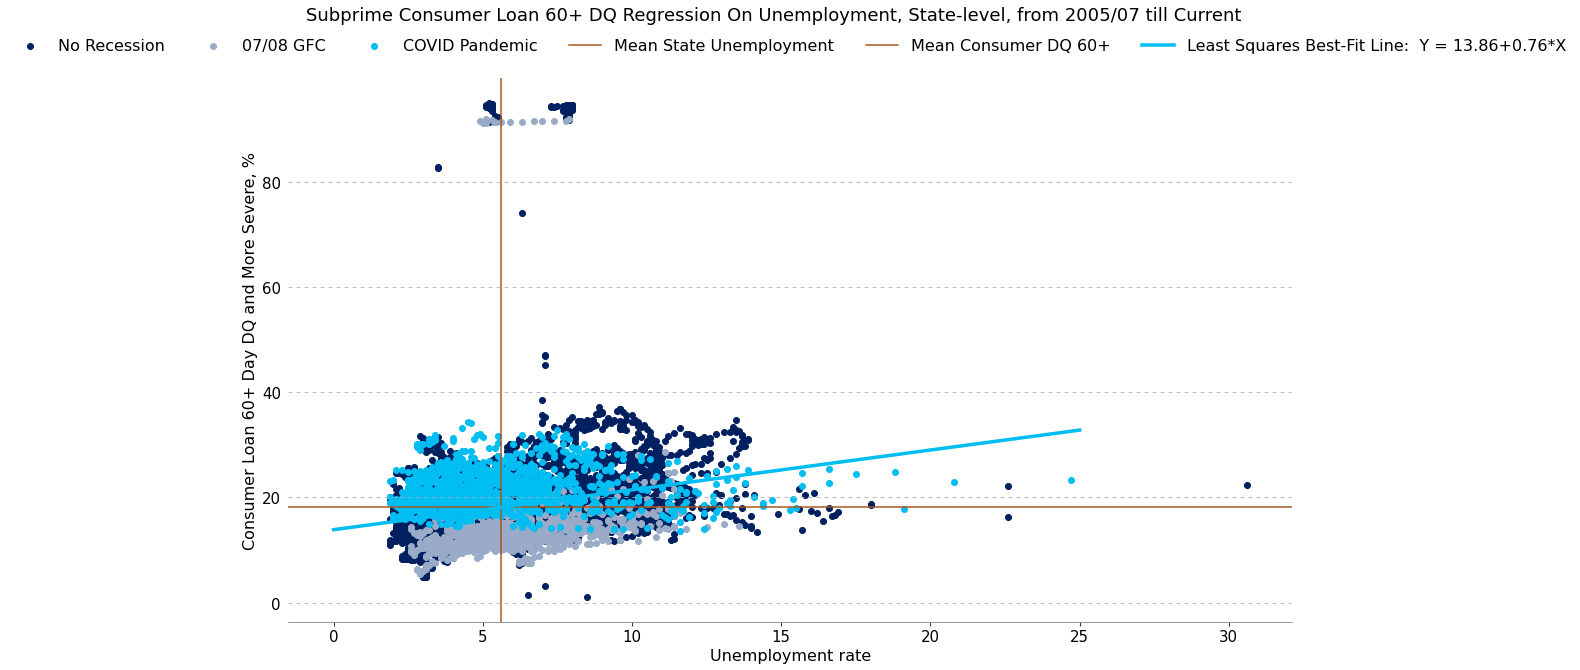

In [41]:
fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(1,1,1)

c = ['#002060','#00BDF2','#99ABC7','#CCF2FC','#99E2E3','#00B0B9','#FFD700','#A9561E','#E6DAA6']

# Plotting the Scatterplot

ax.scatter(x=subprime_merged_df.xs('No Recession',level="is_recession")['unemp_rate'], y=subprime_merged_df.xs('No Recession',level="is_recession")['dq60+_percent'],c=c[0],label='No Recession')
ax.scatter(x=subprime_merged_df.xs('GFC',level="is_recession")['unemp_rate'], y=subprime_merged_df.xs('GFC',level="is_recession")['dq60+_percent'],c=c[2],label='07/08 GFC')
ax.scatter(x=subprime_merged_df.xs('COVID',level="is_recession")['unemp_rate'], y=subprime_merged_df.xs('COVID',level="is_recession")['dq60+_percent'],c=c[1],label='COVID Pandemic')

plt.axvline(x=subprime_merged_df['unemp_rate'].mean(),color = c[7],ls='-', label = 'Mean State Unemployment')
plt.axhline(y=subprime_merged_df['dq60+_percent'].mean(), color = c[7], ls='-', label = 'Mean Consumer DQ 60+')

ax.set_xticklabels([str(i) for i in subprime_merged_df['unemp_rate']], fontsize = 15)
ax.set_yticklabels([str(i) for i in ax.get_yticks()],fontsize=15)

plt.xlabel('Unemployment rate', fontsize = 16)
plt.ylabel('Consumer Loan 60+ Day DQ and More Severe, %', fontsize = 16)


ax.grid(axis='y',linestyle='--',dashes=(5,5))
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

# fit a linear regression via least squares with numpy.polyfit
# It returns a slope (b) and intercept (a)
# deg = 1 means linear fit (i.e. polynomial of degree 1)
b,a = np.polyfit(x=subprime_merged_df['unemp_rate'], y=subprime_merged_df['dq60+_percent'], deg=1)

# Create sequence of 100 numbers from 0 to 100
xseq = np.linspace(0,25,num=100)

# Plot regression line
ax.plot(xseq,a + b* xseq, color = c[1],lw = 3.5, label = "Least Squares Best-Fit Line: " + " Y = " + str(round(a,2)) + "+" + str(round(b,2))+ "*X");

plt.legend(loc = "upper center", ncol=6, prop = {'size':16}, bbox_to_anchor = (0.5,1.1), fancybox =True, frameon = False)

ax.yaxis.set_ticks_position('none')

plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.gca().spines['bottom'].set_color('grey')

fig.suptitle('Subprime Consumer Loan 60+ DQ Regression On Unemployment, State-level, from 2005/07 till Current',fontsize = 18)

plt.show()

In [42]:
save_chart(fig,'Consumer Loan DQ Unemployment Scatterplot (by State), Subprime')

chart saved to the target and BACKUP directory in this following directory: C:\Users\zihao\OneDrive\Desktop\Citi Work\ABS Research\Equifax Dataset Charts\Chart_Content


### Nearprime (Vantage 3.0 Score < 660) Regression

In [43]:
nearprime_merged_df.tail(21)

unemp_rate  dq60+_percent
date       state is_recession                           
2023-04-01 NH    No Recession         2.1       1.005944
           NJ    No Recession         3.5       1.817486
           NM    No Recession         3.5       1.066776
           NV    No Recession         5.4       2.009246
           NY    No Recession         4.0       1.677896
           OH    No Recession         3.7       1.072077
           OK    No Recession         2.9       1.616279
           OR    No Recession         4.0       1.090289
           PA    No Recession         4.1       1.674234
           RI    No Recession         3.0       1.226882
           SC    No Recession         3.1       1.691287
           SD    No Recession         1.9       1.568774
           TN    No Recession         3.3       1.369056
           TX    No Recession         4.0       1.726162
           UT    No Recession         2.3       1.270586
           VA    No Recession         3.1       0.870396
           VT    No Recession         2.4       0.844379
           WA    No Recession         4.3       1.216955
           WI    No Recession         2.4       1.260018
           WV    No Recession         3.3       1.226384
           WY    No Recession         3.5       0.728777

C:\Users\zihao\AppData\Local\Temp\ipykernel_68908\637623779.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i) for i in nearprime_merged_df['unemp_rate']], fontsize = 15)
C:\Users\zihao\AppData\Local\Temp\ipykernel_68908\637623779.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(i) for i in ax.get_yticks()],fontsize=15)


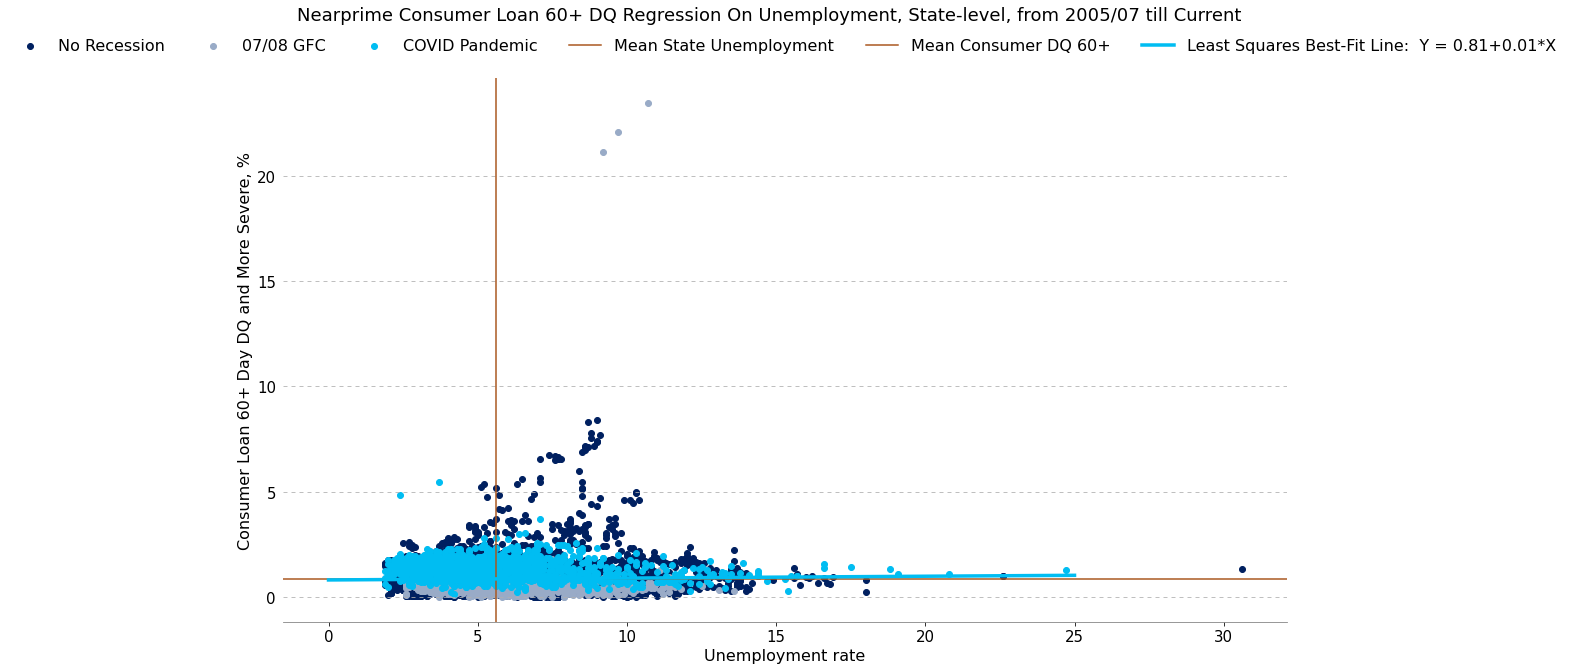

In [44]:
fig = plt.figure(figsize=(18,10))
ax = fig.add_subplot(1,1,1)

c = ['#002060','#00BDF2','#99ABC7','#CCF2FC','#99E2E3','#00B0B9','#FFD700','#A9561E','#E6DAA6']

# Plotting the Scatterplot

ax.scatter(x=nearprime_merged_df.xs('No Recession',level="is_recession")['unemp_rate'], y=nearprime_merged_df.xs('No Recession',level="is_recession")['dq60+_percent'],c=c[0],label='No Recession')
ax.scatter(x=nearprime_merged_df.xs('GFC',level="is_recession")['unemp_rate'], y=nearprime_merged_df.xs('GFC',level="is_recession")['dq60+_percent'],c=c[2],label='07/08 GFC')
ax.scatter(x=nearprime_merged_df.xs('COVID',level="is_recession")['unemp_rate'], y=nearprime_merged_df.xs('COVID',level="is_recession")['dq60+_percent'],c=c[1],label='COVID Pandemic')

plt.axvline(x=nearprime_merged_df['unemp_rate'].mean(),color = c[7],ls='-', label = 'Mean State Unemployment')
plt.axhline(y=nearprime_merged_df['dq60+_percent'].mean(), color = c[7], ls='-', label = 'Mean Consumer DQ 60+')

ax.set_xticklabels([str(i) for i in nearprime_merged_df['unemp_rate']], fontsize = 15)
ax.set_yticklabels([str(i) for i in ax.get_yticks()],fontsize=15)

plt.xlabel('Unemployment rate', fontsize = 16)
plt.ylabel('Consumer Loan 60+ Day DQ and More Severe, %', fontsize = 16)


ax.grid(axis='y',linestyle='--',dashes=(5,5))
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

# fit a linear regression via least squares with numpy.polyfit
# It returns a slope (b) and intercept (a)
# deg = 1 means linear fit (i.e. polynomial of degree 1)
b,a = np.polyfit(x=nearprime_merged_df['unemp_rate'], y=nearprime_merged_df['dq60+_percent'], deg=1)

# Create sequence of 100 numbers from 0 to 100
xseq = np.linspace(0,25,num=100)

# Plot regression line
ax.plot(xseq,a + b* xseq, color = c[1],lw = 3.5, label = "Least Squares Best-Fit Line: " + " Y = " + str(round(a,2)) + "+" + str(round(b,2))+ "*X");

plt.legend(loc = "upper center", ncol=6, prop = {'size':16}, bbox_to_anchor = (0.5,1.1), fancybox =True, frameon = False)

ax.yaxis.set_ticks_position('none')

plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.gca().spines['bottom'].set_color('grey')

fig.suptitle('Nearprime Consumer Loan 60+ DQ Regression On Unemployment, State-level, from 2005/07 till Current',fontsize = 18)

plt.show()